# Exercise 9.1
Literature propose 4 metrics for quantifying the segregation levels from data:

1. **exposure**: the extent to which different populations share the same residential areas; 
2. the **evenness** (and clustering): to which extent populations are evenly spread in the metropolitan area; 
3. **concentration**: to which extent populations concentrate in the areal units they occupy; and 
4. **centralization**: to which extent populations concentrate in the center of the city. 
* Propose 4 simple mathematical formulas for calculate these metrics 
* Implement them in Python/Mesa 
* Create 4 plots that shows the trend of these 4 metrics during the Schelling dynamics (seen in class 11/11/2022)

# Steps followed

* **Wrote the formulas**
* Implemented them into the Class MySchellingAgent (which is the same presented during the lectures)
* Added new features to the Class MySchellingModel:
  
  1. Set the center of the grid as attribute
  2. Added the **new metrics to the Data Collector**
  3. Added the possibility to **plot an animation** of the steps of the model performed
  4. Adjusted the running condition of the model and the step to accomodate for the new features

* Extracted the metrics resulting from a run of the model and plotted them into a matrix plot

# Formulas

I tried to model these 4 metrics in the following way:

* $exposure = \frac{dissimilarity}{tot\_ neighbors}$</br>

With dissimalarity I mean the neighbors different from the agent considered (the opposite of similarity)

* $evenness = \frac{min(similarity, dissimilarity)}{max(similarity, dissimilarity)}* minority\_percentage^{-1}$

While it is zero if undefined for the domain.
Being reciprocal the denominator and the numerator they will be be at most 1 and at least 0, so that it is always defined if at least a neighbor is present. I multiply by the reciprocal of the minority percentage so that I can get a weighted denominator taking into account the difference of size of the two original two population

I'm not implementing it but if I would have to define a clustering metric I would define it as the opposite of evenness as $1 - evenness$.

* $concentration = 1 - \frac{tot\_neighbors - similarity - dissimilarity}{tot\_ neighbors} $

I get the ratio of empty cells in the area, then I get the concentration by getting the specular ratio through the difference of 1 with the previous ratio

* $centralization = \frac{\sqrt{(x - c_x)^2 + (y - c_y)^2}}{grid\_width * \sqrt{2} / 2} $

The distance of the cell from the center of the graph divided by half the diagonal of the grid (which is the maximum possible distance from the center

# Installing Mesa

In [1]:
!pip install mesa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 20.2 MB/s 
     |████████████████████████████████| 66 kB 5.3 MB/s 


# Importing the Packages

In [2]:
from __future__ import annotations
from typing import Any

import numpy as np
import random

# Importing Mesa
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector

# To make the basic plot
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

# To plot the Gif
from IPython import display
from PIL import Image
from io import BytesIO
import imageio

In [3]:
class MySchellingAgent(Agent):
    """
    Schelling segregation agent
    """
    def __init__(self, unique_id, pos, model, agent_type):
        """
        unique_id: id identifying agents
        pos: tuple of (x,y) coordinates
        model: model of agent
        agent_type: could be 1 or 2
        """
        super().__init__(unique_id, model) 
        self.pos = pos
        self.type = agent_type
        self.tot_neighbors=8

    def step(self):
        similarity = 0
        dissimilarity = 0

        neighbors = self.model.grid.iter_neighbors(self.pos, "moore") #Return an iterator over neighbors to a certain point

        for neighbor in neighbors:
            if neighbor.type == self.type:
                similarity += 1
            else:
                dissimilarity += 1

        self.segregation = similarity/self.tot_neighbors

        ########## Here are implemented the Formulas referred above ##########
        self.exposure = dissimilarity/self.tot_neighbors 

        # For evenness I specified for the denominator to be one in case it is not defined
        # If the denominator is 1 the evenness would be in any case defined as zero
        max_threshold = max(similarity, dissimilarity) if similarity != 0 or dissimilarity != 0 else 1
        self.evenness = (min(similarity, dissimilarity) / max_threshold * (1/self.model.minority_pc))
        
        # It is the inverse of an hypthetical agent nearest empty cell ratio
        self.concentration =  1 - ((self.tot_neighbors - similarity - dissimilarity) / self.tot_neighbors)
        
        # I compute the distance from the center of the grid
        self.centralization = (((self.pos[0] - self.model.center[0])**2 + (self.pos[1] - self.model.center[1])**2) / self.model.side * (2**(1/2) / 2))

        # Either moving if unhappy or adding happiness
        if self.segregation < self.model.homophily:
            self.model.grid.move_to_empty(self)
        else:
            self.model.total_happiness += 1

In [4]:
class MySchellingModel(Model):
    """
    Model class for the Schelling segregation model.
    """

    def __init__(self, *args: Any, **kwargs: Any) -> None:
        """
        Default Attributes:
            schedule: schedule object initialized with a random activation
            running: a bool indicating if the model should continue running

        Default Parameters:
            side: side of the grid square = 10
            density: density of population = 0.7
            minority_pc: percentage of minority type (2 types in ths case) = 0.3
            homophily: percentage of neighbours requested of same type = 0.3
        """

        self.schedule = RandomActivation(self)
        self.current_id = 0                     # Id of the Agent
        self.step_counter = 0                   # Current step of the model
        self.plot_images = list()               # To store the plot of each step

        # Default Parameters
        self.side = kwargs.get("side", 10)
        self.density = kwargs.get("density", 0.7)
        self.minority_pc = kwargs.get("minority_pc", 0.3)
        self.homophily = kwargs.get("homophily", 0.3)

        # Grid where each cell contains exactly at most one object. default rectangular
        self.grid = SingleGrid(width=self.side, height=self.side, torus=False)

        # Adding the center useful for the centralization metric
        self.center = self.side // 2, self.side // 2

        # Reset total happy agents counting
        self.total_happiness = 0
        
        # Initializing the Data Collector with all the metrics
        model_reporters = {"Percentage_happiness": lambda m: m.total_happiness / m.schedule.get_agent_count(),
                           "Total_Segregation": lambda m: np.mean([a.segregation for a in self.schedule.agents]),
                           "Total_Exposure": lambda m: np.mean([a.exposure for a in self.schedule.agents]),
                           "Total_Evenness": lambda m: np.mean([a.evenness for a in self.schedule.agents]),
                           "Total_Concentration": lambda m: np.mean([a.concentration for a in self.schedule.agents]),
                           "Total_Centralization": lambda m: np.mean([a.centralization for a in self.schedule.agents])}
        agent_reporters = {"x": lambda a: a.pos[0], "y": lambda a: a.pos[1], 
                           "segregation": lambda a: a.segregation,
                           "exposure" : lambda a: a.exposure,
                           "evenness" : lambda a: a.evenness,
                           "concentration" : lambda a: a.concentration,
                           "centralization" : lambda a: a.centralization}

        # Initializing the Agents
        for cell in self.grid.coord_iter(): #looping across cells with .coord_iter()
            x = cell[1]
            y = cell[2]

            if random.random() < self.density:   # If true, selected cell is populated, else is empty
                
                # If true, cell is populated with minority, else with majority type
                agent_type = 1 if random.random() < self.minority_pc else 2

                # Instantiating a SchellingAgent
                agent = MySchellingAgent(self.current_id, (x, y), self, agent_type)

                self.next_id()                             #Moving to the next id
                self.grid.position_agent(agent, (x, y))    #Positions an agent on the grid, and set its pos variable.                        
                self.schedule.add(agent)                   #Add an Agent object to the schedule.

        # Initializing the Data Collector
        self.datacollector = DataCollector(model_reporters, agent_reporters)

        # Adding initial situation to the stored images
        self.plot(show = False, store = True)
        self.plot_images.append(self.image)

    def run_model(self) -> None:
        """Run the model until all agents are happy."""
        #while running is True and the total happiness is n
        while self.total_happiness != self.schedule.get_agent_count():
            self.step()

    def step(self) -> None:
        """Run one step of the model."""
        self.total_happiness = 0              # Reset counter of happy agents
        self.schedule.step()                  # Call agents steps
        self.step_counter += 1                # Increasing the step counter

        self.plot(show = False, store = True) # To store the plot Image
        self.plot_images.append(self.image)   # To add the plot image to the list attribute

        self.datacollector.collect(self)      # Collect all the data for the given model object

    def plot(self, show = True, store = False):
        """Plot the current status of the model"""
        # Creating a matrix to store the position of the agents
        agent_counts = np.zeros((self.grid.width, self.grid.height))

        for cell in self.grid.coord_iter(): # Iterating through the cells
            cell_content, x, y = cell
            if cell_content != None: # If something is in the cell
                agent_counts[x][y] = cell_content.type # Add Agent Type to the matrix

        # Plotting the matrix
        cmap = colors.ListedColormap(['white', '#ff3300','#0033ff'])
        plt.imshow(agent_counts, interpolation="nearest", cmap=cmap)
        ax = plt.gca()

        # Add the ticks and set the grid
        major_ticks = np.arange(-0.5,self.side-0.5,1)
        ax.set_xticks(major_ticks)
        ax.set_yticks(major_ticks)
        ax.grid(True)

        # Remove the labels and add the Title
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(f"Schelling model: Step {self.step_counter}")

        # If the image is requested to be stored
        if store == True:
            buffer_store = BytesIO()                  # Creating a buffer to store the image in
            plt.savefig(buffer_store, format='png')   # Store the image into the buffer
            self.image = Image.open(buffer_store)     # Save the open image into the model attribute
        
        if show == True:
            plt.show()
        # In case the plot is not requested at the moment it will be closed
        else:
            plt.close()

    def gif(self, gif_path = 'Schelling_Animation.gif'):
        """A gif of the current steps of the model performed will be shown"""

        # Saving a gif into the gif path
        imageio.mimsave(gif_path, self.plot_images, fps=2)

        # Open the gif for showing it into the notebook
        return display.Image(data=open(gif_path,'rb').read(), format='png')

    def __get_df_model__(self):
        return self.datacollector.get_model_vars_dataframe()

    def __get_df_agents__(self):
        return self.datacollector.get_agent_vars_dataframe()

# Plotting a run of the model

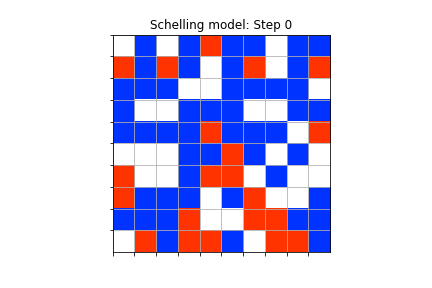

In [12]:
istance = MySchellingModel()

for _ in range(20):
    istance.step()

istance.gif()

# Plotting the 4 metrics for this run

In [13]:
# to plot a column of the dataframe
def call_metric(istance, metric):
    plt.plot(istance.__get_df_model__()[metric])

# to get the name of the metric in the model
def get_metrics(istance):
    return istance.__get_df_model__().columns

As it can be seen the happiness, segregation and concentration tend to increase, because the rules of the model if a convergence is possible make it so that agents try to get together (even though some times concentration has a less stable growth probably because of some unlucky movements). 

Exposure and Evenness decrease instead as the first is reduced for the inverse reason of the one just exposed, while evenness is reduced by people converging to clusters.

Centralization is bit more aleatory (it doesn't always decrease after some tests) even though it seems to decrease suddenly after a few steps, sometimes it starts to increase with some specific convergence after a while. It may be that a random disposition of agents at first is broken up outwards as it would be difficult for both populations to converge in the center of the grid but sometimes it happen that the two distribution are closer to the center

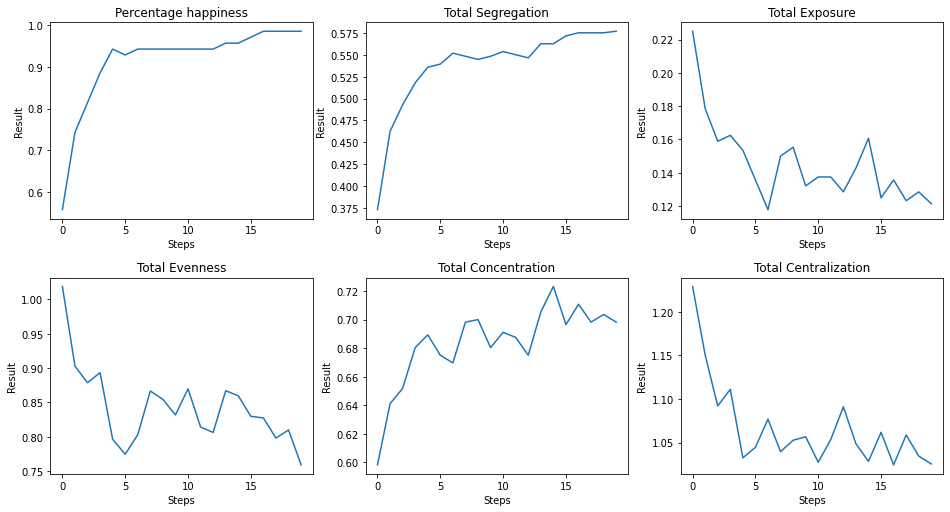

In [14]:
fig = plt.figure(figsize=(16, 13)) 
fig_dims = (3, 3)

for n, metric in enumerate(get_metrics(istance)):
    plt.subplot2grid(fig_dims, (n // 3, n - 3*(n // 3)), title=metric.replace('_', ' '))
    call_metric(istance, metric)
    plt.xlabel('Steps')
    plt.ylabel('Result')
    
plt.subplots_adjust(hspace=0.3)
plt.show()